In [11]:
from hydrodata import Station
import hydrodata.datasets as hds
from hydrodata import plot
from hydrodata import services
from arcgis2geojson import arcgis2geojson
import matplotlib.pyplot as plt
import geopandas as gpd
import warnings

In [2]:
warnings.filterwarnings("ignore")

# Quick Guide

Here are some examples to quickly get you started with basic capabilities of HydroData. The rest of documentation details other funtionalities of HydroData in more details.

## Station

`Station` provides some information for a USGS station based on ID or coordinates (longitude and latitude). It requires at least three parameters: start date, end date and a USGS station ID or coordinates. Let's consider the following USGS station:

In [3]:
station_id = '01031500'
start, end = '2000-01-01', '2010-01-21'

Upon instantiation, the station and its watershed characteristics are found using [NLDI](https://labs.waterdata.usgs.gov/about-nldi/) and [USGS Site Information](https://waterdata.usgs.gov/nwis/si) services.

In [4]:
wshed = Station(start, end, station_id=station_id)

[ID: 01031500] Using existing watershed geometry: data/01031500/geometry.gpkg
[ID: 01031500] Watershed: Piscataquis River near Dover-Foxcroft, Maine
               Coordinates: (-69.315, 45.175)
               Altitude: 109 m above NGVD29
               Drainage area: 772 sqkm.


## NHDPlus

The river network including tributaries and main river channel for the watershed can be retrived from NHDPlus database. Additionally, using the retrieved information such as the watershed geometry we can then use the `datasets` module to access other databases. For example, we can find the USGS stations upstream (or downstream) of the main river channel (or tributatires) up to a certain distance, say 150 km. Also, all the USGS stations inside the watershed can be found:

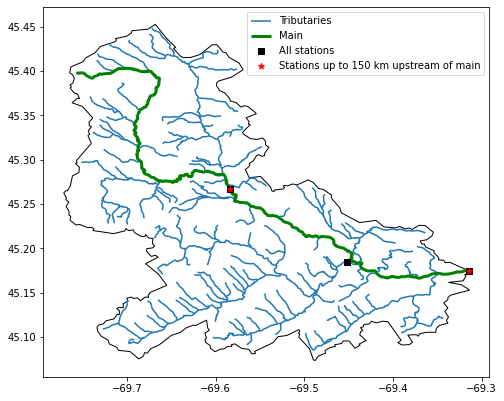

In [5]:
tributaries = hds.NLDI.tributaries(wshed.station_id)
main_channel = hds.NLDI.main(wshed.station_id)
stations = hds.NLDI.stations(wshed.station_id)
stations_upto_150 = hds.NLDI.stations(wshed.station_id, navigation="upstreamMain", distance=150)

ax = wshed.basin.plot(color='white', edgecolor='black', zorder=1, figsize = (8, 8))
tributaries.plot(ax=ax, label='Tributaries', zorder=2)
main_channel.plot(ax=ax, color='green', lw=3, label='Main', zorder=3)
stations.plot(ax=ax, color='black', label='All stations', marker='s', zorder=4)
stations_upto_150.plot(ax=ax, color='red', label='Stations up to 150 km upstream of main', marker='*', zorder=5)
ax.legend(loc='best');

## Data for Single Pixel 

The climate data and streamflow observations for the location of interest can be retrieved and plotted using ``plot`` module that can plot five hydrologic signatures graphs in one plot.

In [7]:
clm_loc = hds.daymet_byloc(wshed.lon, wshed.lat, start=wshed.start, end=wshed.end)
clm_loc['Q (cms)'] = hds.nwis_streamflow(wshed.station_id, wshed.start, wshed.end)

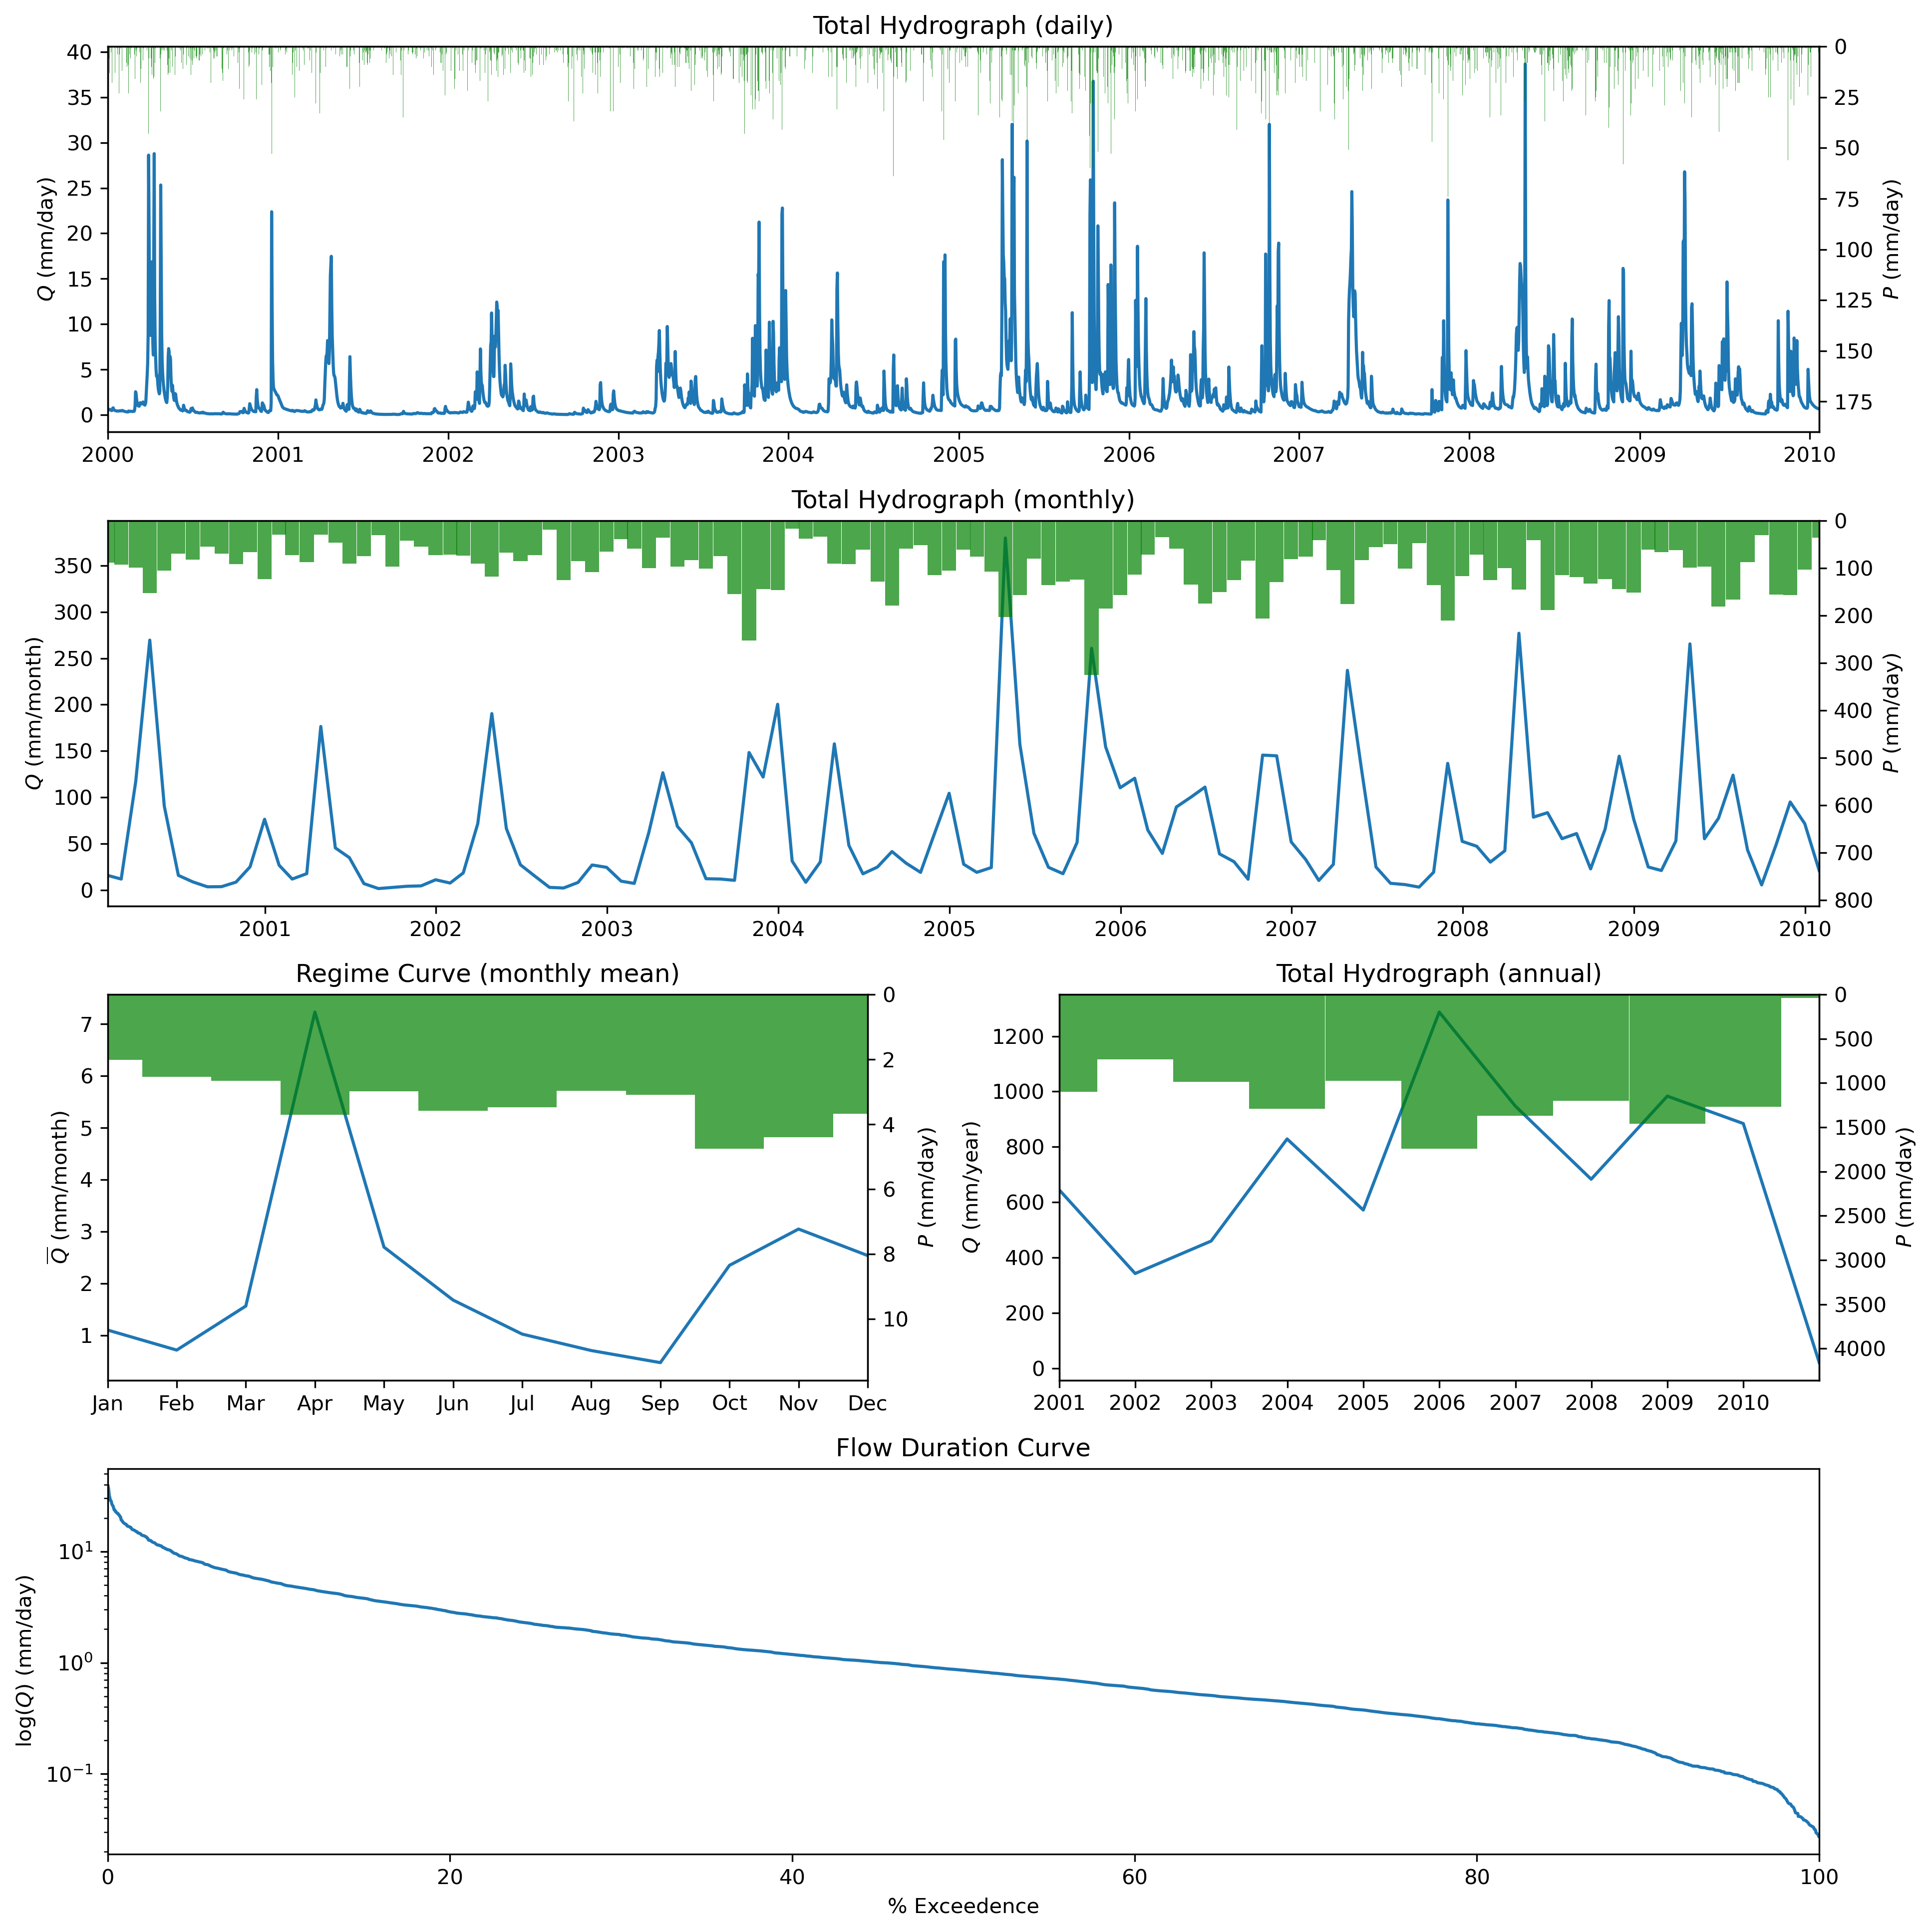

In [8]:
plot.signatures({"Q": (clm_loc['Q (cms)'], wshed.drainage_area)}, clm_loc["prcp (mm/day)"])

## Gridded Datasets

Other than point-based data, gridded data can also be accessed at the desired resolution. Furthermore, the watershed geometry can be used to mask the gridded data.

DEM can be retrieved for the station's contributing watershed at 1 arc-second (30 m) resolution, as follows:

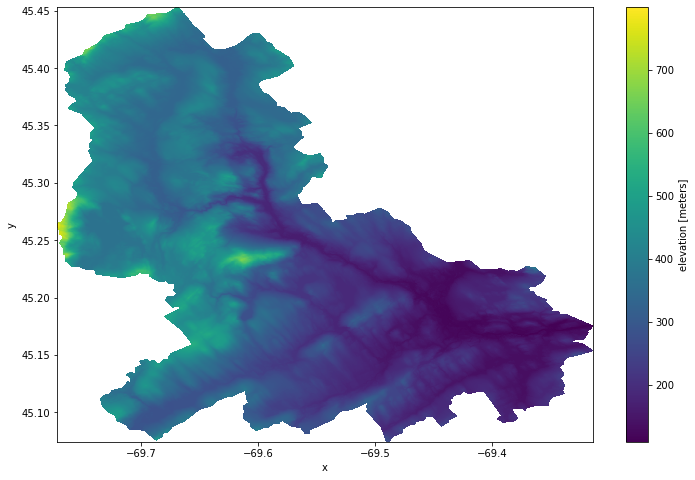

In [6]:
dem = hds.nationalmap_dem(wshed.geometry, resolution=1)
dem.plot(size=8);

In [9]:
variables = ["tmin", "tmax", "prcp"]
clm_grd = hds.daymet_bygeom(wshed.geometry, start='2005-01-01', end='2005-01-31', variables=variables, pet=True)
eta_grd = hds.ssebopeta_bygeom(wshed.geometry, start='2005-01-01', end='2005-01-31')

All the gridded data are returned as [xarray](https://xarray.pydata.org/en/stable/) datasets that has efficient data processing tools. Note that Daymet dataset's projection is [Lambert](https://daymet.ornl.gov/overview).

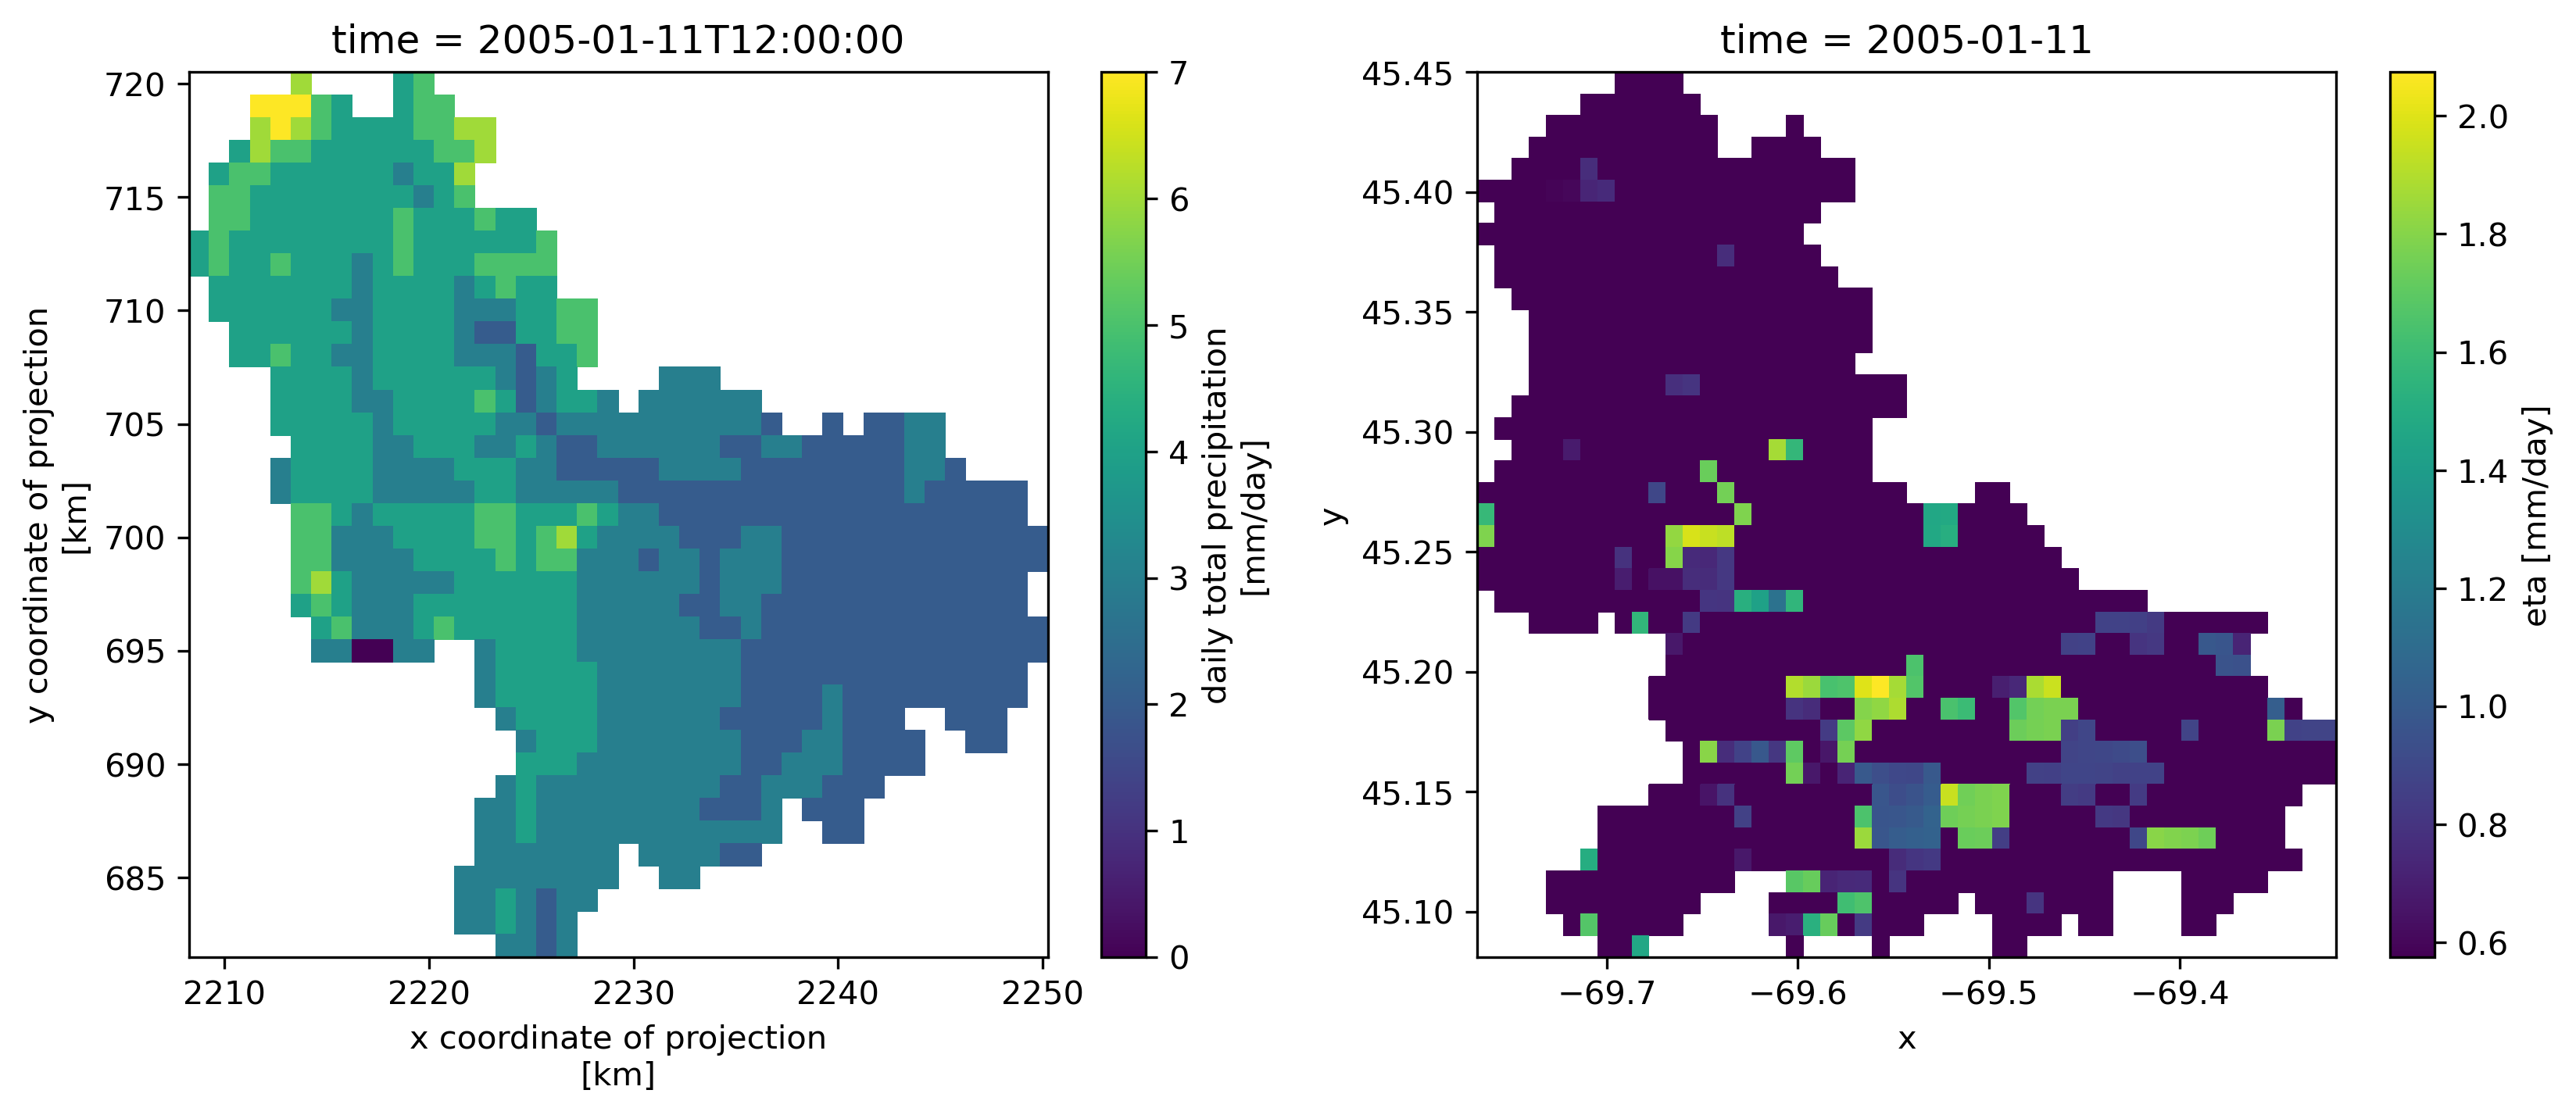

In [17]:
fig, axes = plt.subplots(ncols=2, figsize=(13, 5))
clm_grd.prcp.isel(time=10).plot(ax=axes[0])
eta_grd.eta.isel(time=10).plot(ax=axes[1]);

## Adding Database

The ``services`` module can be used for accessing [Los Angeles GeoHub](http://geohub.lacity.org/) RESTful service, NationalMap's [3D Eleveation Program](https://www.usgs.gov/core-science-systems/ngp/3dep) via WMS and [FEMA National Flood Hazard Layer](https://www.fema.gov/national-flood-hazard-layer-nfhl) via WFS for a watershed in Los Angeles:

In [10]:
la_wshed = Station('2005-01-01', '2005-01-31', '11092450')

url_rest = "https://maps.lacity.org/lahub/rest/services/Stormwater_Information/MapServer/10"
s = services.ArcGISREST(url_rest, outFormat="json")
s.get_featureids(la_wshed.geometry)
storm_pipes = s.get_features()

url_wms = "https://elevation.nationalmap.gov/arcgis/services/3DEPElevation/ImageServer/WMSServer"
slope = services.wms_bygeom(
                  url_wms,
                  geometry=la_wshed.geometry,
                  version="1.3.0",
                  layers={"slope": "3DEPElevation:Slope Degrees"},
                  outFormat="image/tiff",
                  resolution=1)

url_wfs = "https://hazards.fema.gov/gis/nfhl/services/public/NFHL/MapServer/WFSServer"
r = services.wfs_bybox(
                   url_wfs,
                   bbox=la_wshed.geometry.bounds,
                   version="2.0.0",
                   layer="public_NFHL:Base_Flood_Elevations",
                   outFormat="esrigeojson",
                   in_crs="epsg:4326",
                   out_crs="epsg:4269")
flood = gpd.GeoDataFrame.from_features(arcgis2geojson(r.json()),
                                       crs="epsg:4269").to_crs("epsg:4326")

[ID: 11092450] Using existing watershed geometry: data/11092450/geometry.gpkg
[ID: 11092450] Watershed: LOS ANGELES R A SEPULVEDA DAM CA
               Coordinates: (-118.467, 34.162)
               Altitude: 202 m above NGVD29
               Drainage area: 409 sqkm.
